In [1]:
!pip install tensorflow_addons
!pip install vit-keras

# Vision Transformer (ViT)

inspired by this [notebook](https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from vit_keras import vit, utils
from vit_keras import visualize

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# sys.path.append('../')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

<module 'leukopy_lib' from '/kaggle/usr/lib/leukopy_lib/leukopy_lib.py'>

# Set up

## Generate dataframes

In [3]:
# pa/kaggle/ = Path('main_dataset/')
INPUT_PATH = Path('../input/main-dataset/main_dataset/')

df_train = leuko.generate_images_df(INPUT_PATH/'training_set')
df_test = leuko.generate_images_df(INPUT_PATH/'testing_set')
df_valid = leuko.generate_images_df(INPUT_PATH/'validation_set')

df_train.head()

,img_path,cell_type,label,label_2,label_3
0,../input/main-dataset/main_dataset/training_se...,training_set,BA,BA,BA
1,../input/main-dataset/main_dataset/training_se...,training_set,BNE,IG,BNE
2,../input/main-dataset/main_dataset/training_se...,training_set,MO,MO,MO
3,../input/main-dataset/main_dataset/training_se...,training_set,MY,IG,IG
4,../input/main-dataset/main_dataset/training_se...,training_set,BA,BA,BA


### choose classes

In [4]:
N_CLASSES, df_train, df_test, df_valid = leuko.choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [5]:
N_CLASSES

11

In [6]:
df_train["label"].value_counts()

EO     2349
PLT    1739
SNE    1263
BNE    1212
ERB    1162
MO     1068
LY      944
BA      903
MY      833
MMY     734
PMY     460
Name: label, dtype: int64

## Image generator

For ViT image are patched into [16x16](https://arxiv.org/abs/2010.11929) images ("images is worth 16x16 words")

In [7]:
BATCH_SIZE = 32
IMG_SIZE  = 352 #need to be a multiple of patch size = 16
EPOCHS = 100
LR = 1e-3

In [8]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     horizontal_flip = True, 
                                     vertical_flip = True,
                                     shear_range = 0.1)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # uses x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # uses y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # uses x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (IMG_SIZE, IMG_SIZE), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # uses y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # uses x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 color_mode = 'rgb',
                                                 classes = None,   # uses y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12667 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


### Visualise images and attention

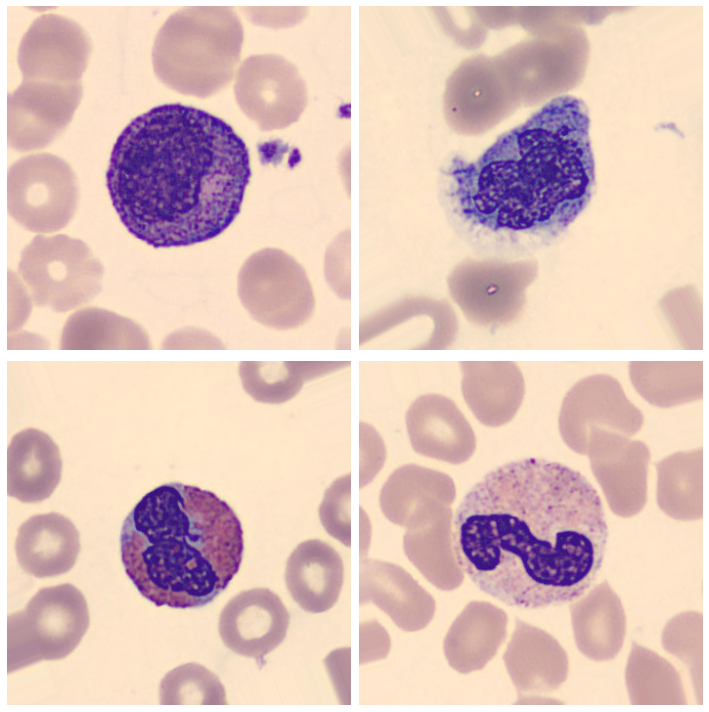

In [9]:
images = [training_set[0][0][i] for i in range(5)]
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMG_SIZE, IMG_SIZE, 3).astype('uint8'))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# classes = utils.get_imagenet_classes()

vit_model = vit.vit_b16(
    weights='imagenet21k+imagenet2012',
        image_size = IMG_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False, #fine tune
        classes = N_CLASSES)


347504640/347502902 [==============================] - 6s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 22, 22
  UserWarning,


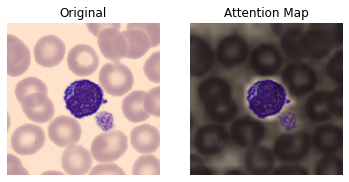

In [11]:
x = testing_set.next()
image = x[0][0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image.astype('uint8'))
_ = ax2.imshow(attention_map)

In [12]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 352, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 22, 22, 768)       590592    
_________________________________________________________________
reshape (Reshape)            (None, 484, 768)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 485, 768)          768       
_________________________________________________________________
Transformer/posembed_input ( (None, 485, 768)          372480    
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 485, 768), (None, 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 485, 768), (None, 7087

In [13]:
temp_model = tf.keras.Sequential([
    vit_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation = tfa.activations.gelu, name = 'dense_1'),
    layers.BatchNormalization(),
    layers.Dense(11, 'softmax')
    ])

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [14]:
def find_layer(model, layer_name):
    for (i, layer) in enumerate(model.layers):
        if layer.name == layer_name:
            return (i, layer)
    
def model_surgery(model):
    submodel_index, submodel = find_layer(model, 'vit-b16')
    x = submodel.outputs[0]
    for layer_index in range(submodel_index+1, len(model.layers)):
        extracted_layer = model.layers[layer_index]
        print('Surgically appending layer : '+str(extracted_layer))
        x = extracted_layer(x)
    new_model = Model(inputs=submodel.inputs, outputs=[x])
    return new_model

model = model_surgery(temp_model)
model.summary()

Surgically appending layer : <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc0702ebfd0>
Surgically appending layer : <tensorflow.python.keras.layers.core.Dense object at 0x7fc0841089d0>
Surgically appending layer : <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc0702e2a90>
Surgically appending layer : <tensorflow.python.keras.layers.core.Dense object at 0x7fc0702eb090>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 352, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 22, 22, 768)       590592    
_________________________________________________________________
reshape (Reshape)            (None, 484, 768)          0         
_________________________________________________________________
class_token (

In [15]:
for layer in model.layers[:-11]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer, layer.trainable)
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc0a605b4d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc0a59719d0> False
<tensorflow.python.keras.layers.core.Reshape object at 0x7fc0a62bfd50> False
<vit_keras.layers.ClassToken object at 0x7fc0a5a2cad0> False
<vit_keras.layers.AddPositionEmbs object at 0x7fc0a5a5b610> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a5a20e50> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a423ee10> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a41ee450> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a420e990> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a40d71d0> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a4173810> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a4078490> False
<vit_keras.layers.TransformerBlock object at 0x7fc0a40fe510> True
<vit_keras.layers.TransformerBlock object at 0x7fc09c1d44d0> True
<vit_keras.layers.Trans

In [16]:
f1_metric = tfa.metrics.F1Score(num_classes=11, average='macro', name='f1')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LR)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.05),
              metrics = ['accuracy', f1_metric, precision, recall])

In [17]:
from datetime import datetime

t = datetime.now().strftime("%d%m%Y_%H")

path = Path(f'../working/model_save/vit_b16/{t}')
path.mkdir(parents=True, exist_ok=True)

In [18]:
# Callbacks


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-7,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 7,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = path/'model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks_list = [earlystopping, reduce_lr, checkpointer]

In [19]:
## Compute weights :
class_weights = leuko.compute_weights(training_set, method = 3)
class_weights

{0: 7.0138427464008855,
 1: 5.225660066006601,
 6: 5.930243445692884,
 7: 7.603241296518607,
 2: 2.696253724989357,
 8: 3.642035652673951,
 10: 5.0146476642913695,
 3: 5.450516351118761,
 4: 6.709216101694915,
 9: 13.768478260869566,
 5: 8.628746594005449}

In [20]:
## Training :
epochs = 100
training_history = model.fit(x = training_set, 
                             steps_per_epoch = training_set.n/training_set.batch_size,
                             validation_steps = validation_set.n/validation_set.batch_size,

                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set, 
                             class_weight = class_weights
                            )

model.save(path)

Epoch 1/100
395/395 [==============================] - 679s 2s/step - loss: 11.4248 - accuracy: 0.4025 - f1: 0.3512 - precision: 0.5866 - recall: 0.2892 - val_loss: 1.0318 - val_accuracy: 0.7289 - val_f1: 0.6189 - val_precision: 0.8316 - val_recall: 0.6595

Epoch 00001: val_accuracy improved from -inf to 0.72890, saving model to ../working/model_save/vit_b16/31102021_10/model.hdf5
Epoch 2/100
395/395 [==============================] - 602s 2s/step - loss: 5.5289 - accuracy: 0.7587 - f1: 0.6997 - precision: 0.8459 - recall: 0.6724 - val_loss: 0.8943 - val_accuracy: 0.7514 - val_f1: 0.6763 - val_precision: 0.8081 - val_recall: 0.7035

Epoch 00002: val_accuracy improved from 0.72890 to 0.75145, saving model to ../working/model_save/vit_b16/31102021_10/model.hdf5
Epoch 3/100
395/395 [==============================] - 596s 2s/step - loss: 4.8892 - accuracy: 0.7889 - f1: 0.7385 - precision: 0.8584 - recall: 0.7050 - val_loss: 1.0103 - val_accuracy: 0.7121 - val_f1: 0.6624 - val_precision: 0.

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


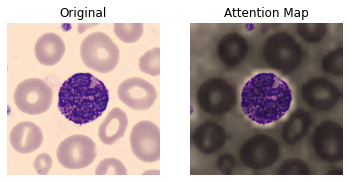

In [30]:
x = testing_set.next()
image = x[0][0]

attention_map = visualize.attention_map(model = model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image.astype('uint8'))
_ = ax2.imshow(attention_map)

In [22]:
import pickle

with open(path/'training_hist_b16', 'wb') as f:
    pickle.dump(training_history.history, f)

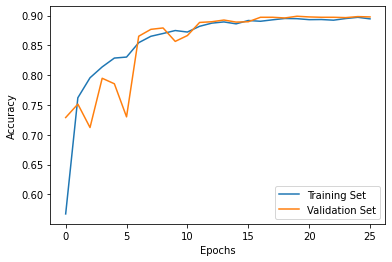

In [23]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(earlystopping.stopped_epoch), training_accuracy[0:earlystopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(earlystopping.stopped_epoch), validation_accuracy[0:earlystopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
model.evaluate(testing_set)


80/80 [==============================] - 50s 626ms/step - loss: 0.5426 - accuracy: 0.8919 - f1: 0.8625 - precision: 0.9136 - recall: 0.8687


[0.5426194667816162,
 0.891902506351471,
 0.8624870777130127,
 0.9136006832122803,
 0.8687106966972351]

In [25]:
model.evaluate(validation_set)

55/55 [==============================] - 34s 619ms/step - loss: 0.5381 - accuracy: 0.8988 - f1: 0.8685 - precision: 0.9181 - recall: 0.8751


[0.5380927324295044,
 0.8988439440727234,
 0.8685316443443298,
 0.9181321859359741,
 0.8751444816589355]

In [26]:
predictions = model.predict(testing_set)
y_pred = tf.argmax(predictions, axis = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [27]:
test_label_map = {v:k for k, v in testing_set.class_indices.items()}
df_pred = pd.DataFrame({'true':testing_set.classes,
                        'true_label':df_test['label'],
                        'pred':y_pred,
                        'img_path':df_test['img_path']})
df_pred['pred_label'] = df_pred['pred'].map(test_label_map)
df_pred.to_pickle(path/'pred_b16.pk')
df_pred

,true,true_label,pred,img_path,pred_label
0,4,LY,4,../input/main-dataset/main_dataset/testing_set...,LY
1,10,SNE,10,../input/main-dataset/main_dataset/testing_set...,SNE
2,0,BA,7,../input/main-dataset/main_dataset/testing_set...,MY
3,0,BA,0,../input/main-dataset/main_dataset/testing_set...,BA
4,3,ERB,3,../input/main-dataset/main_dataset/testing_set...,ERB
...,...,...,...,...,...
2539,1,BNE,1,../input/main-dataset/main_dataset/testing_set...,BNE
2540,10,SNE,10,../input/main-dataset/main_dataset/testing_set...,SNE
2541,3,ERB,3,../input/main-dataset/main_dataset/testing_set...,ERB
2542,4,LY,4,../input/main-dataset/main_dataset/testing_set...,LY


Text(0.5, 51.0, 'Predicted label')

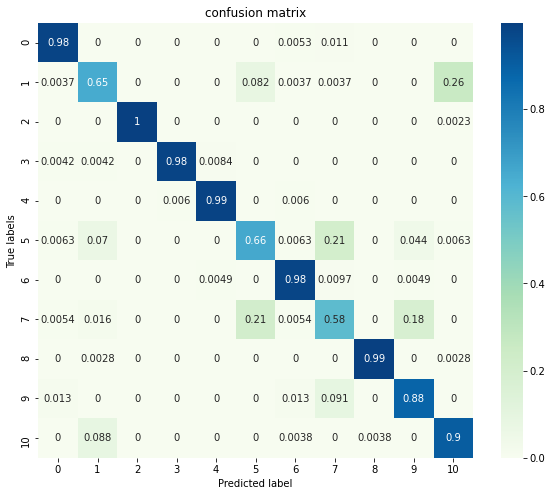

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(testing_set.classes, y_pred, normalize='true'), 
            annot=True, cmap='GnBu', square=True)
plt.title('confusion matrix')
plt.ylabel('True labels')
plt.xlabel('Predicted label')

In [29]:
pd.DataFrame.from_dict(classification_report(testing_set.classes, 
                                             y_pred, 
                                             target_names=testing_set.class_indices,
                                             output_dict=True)).transpose()

,precision,recall,f1-score,support
BA,0.973822,0.984127,0.978947,189.000000
BNE,0.816901,0.649254,0.723493,268.000000
EO,1.000000,0.997685,0.998841,432.000000
ERB,0.995726,0.983122,0.989384,237.000000
LY,0.982249,0.988095,0.985163,168.000000
MMY,0.630303,0.658228,0.643963,158.000000
MO,0.966507,0.980583,0.973494,206.000000
MY,0.703947,0.581522,0.636905,184.000000
PLT,0.997238,0.994490,0.995862,363.000000
PMY,0.623853,0.883117,0.731183,77.000000
